# **Implementation of Wasserstein Generative Adversarial Networks with Gradient Penalty (WGANGP)**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

In [ ]:
TRAIN_SIZE = 60000
BATCH_SIZE = 512
TEST_SIZE = 10000
DATA_DIM = (28, 28, 1)
N_TRAIN_BATCHES = int(TRAIN_SIZE/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_SIZE/BATCH_SIZE)
N_Z = 64

In [ ]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype("float32") / 255.0
test_images = test_images.reshape(test_images.shape[0],28,28,1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_SIZE)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_SIZE)
    .batch(BATCH_SIZE)
)

4422102/4422102 [==============================] - 0s 0us/step


### Define the network as tf.keras.model object

In [ ]:
class WGANGP(tf.keras.Model):

    def __init__(self, **kwargs):
        super(WGANGP, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):

        # generating noise from a uniform distribution
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)

        # gradient penalty
        d_regularizer = self.gradient_penalty(x, x_gen)
        # losses
        disc_loss = (
            tf.reduce_mean(logits_x)
            - tf.reduce_mean(logits_x_gen)
            + d_regularizer * self.gradient_penalty_weight
        )

        # losses of fake with label "1"
        gen_loss = tf.reduce_mean(logits_x_gen)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)

        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )

    def gradient_penalty(self, x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
        x_hat = epsilon * x * x_gen

        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = self.discriminate(x_hat)

        gradients = t.gradient(d_hat, x_hat)

        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))

        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)

        return d_regularizer

    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)

### Define the network architecture

In [ ]:
generator = [
    tf.keras.layers.Dense(units=7*7*64, activation='relu'),
    tf.keras.layers.Reshape(target_shape=(7,7,64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2,2), padding='SAME', activation='relu'
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2,2), padding='SAME', activation='relu'
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1,1), padding='SAME', activation='sigmoid'
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=DATA_DIM),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2,2), activation='relu'
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2,2), activation='relu'
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
]

### Create Model

In [ ]:
# optimizers
gen_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.0005)# train the model

# model
model = WGANGP(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = N_Z,
    gradient_penalty_weight = 10.0
)

### Train the model

In [ ]:
# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE,N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

In [ ]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

100%|██████████| 19/19 [00:01<00:00, 15.12it/s]


Epoch: 0 | disc_loss: 0.020860590040683746 | gen_loss: 0.265089750289917


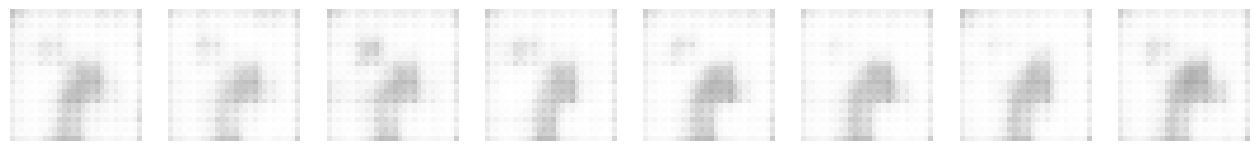

100%|██████████| 19/19 [00:00<00:00, 22.91it/s]


Epoch: 1 | disc_loss: -0.7826381921768188 | gen_loss: 0.8571041226387024


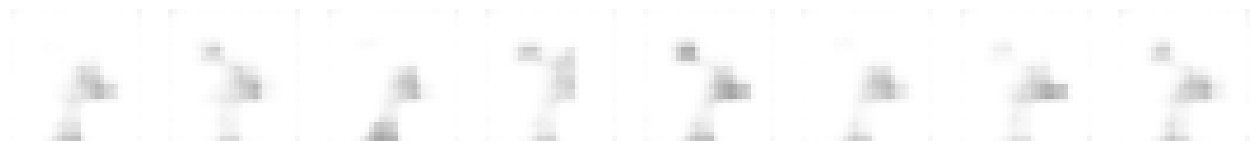

100%|██████████| 19/19 [00:00<00:00, 36.17it/s]


Epoch: 2 | disc_loss: -0.8451768159866333 | gen_loss: 0.8624327778816223


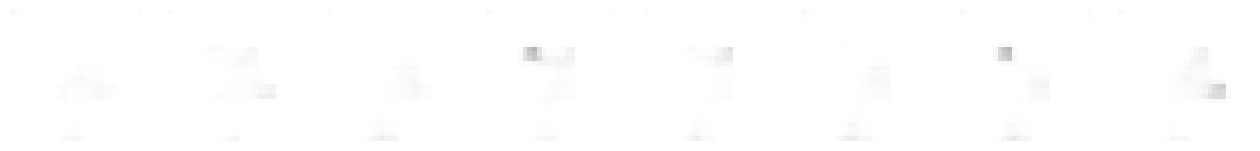

100%|██████████| 19/19 [00:00<00:00, 36.59it/s]


Epoch: 3 | disc_loss: -0.8397533297538757 | gen_loss: 0.8956835865974426


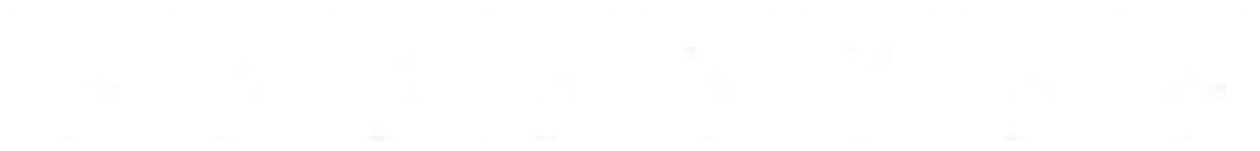

100%|██████████| 19/19 [00:00<00:00, 33.08it/s]


Epoch: 4 | disc_loss: -0.8480525016784668 | gen_loss: 0.8992855548858643


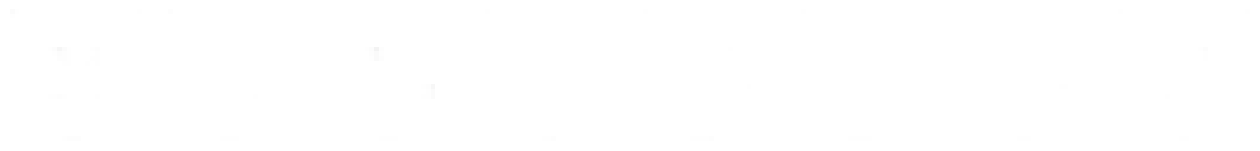

100%|██████████| 19/19 [00:00<00:00, 37.19it/s]


Epoch: 5 | disc_loss: -0.859774649143219 | gen_loss: 0.8606407046318054


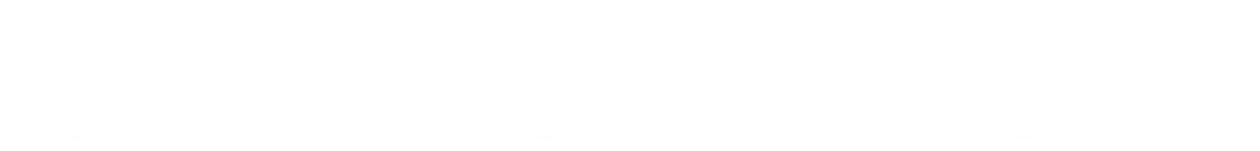

100%|██████████| 19/19 [00:00<00:00, 20.79it/s]


Epoch: 6 | disc_loss: -0.853790283203125 | gen_loss: 0.9131320118904114


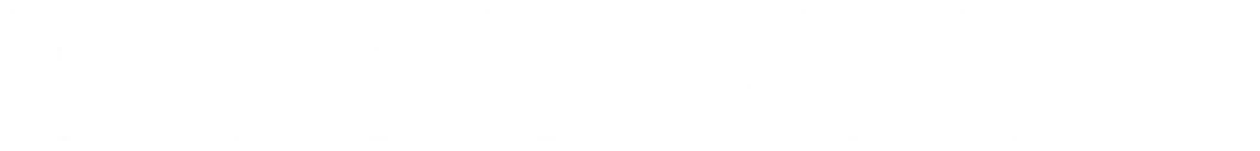

100%|██████████| 19/19 [00:01<00:00, 17.73it/s]


Epoch: 7 | disc_loss: -0.8685282468795776 | gen_loss: 0.9025921821594238


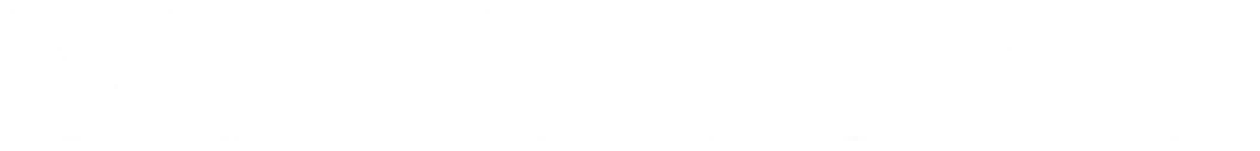

100%|██████████| 19/19 [00:01<00:00, 13.51it/s]


Epoch: 8 | disc_loss: -0.8768788576126099 | gen_loss: 0.8988049030303955


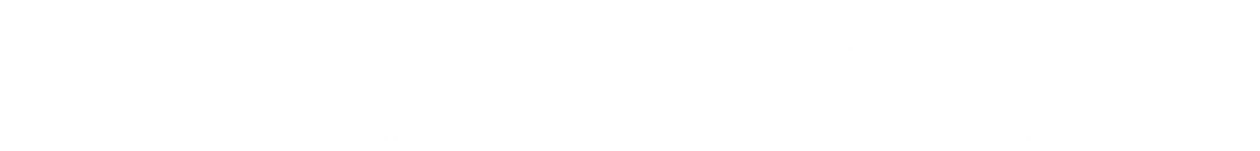

100%|██████████| 19/19 [00:01<00:00, 15.03it/s]


Epoch: 9 | disc_loss: -0.9149249196052551 | gen_loss: 0.9191024899482727


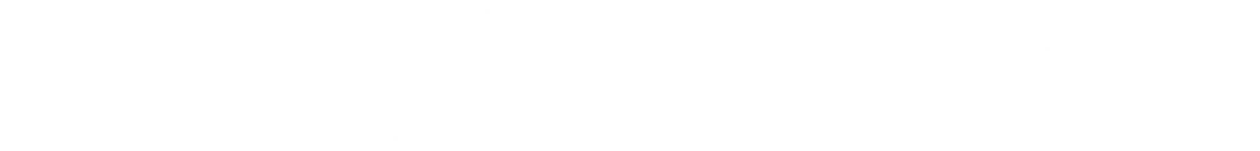

100%|██████████| 19/19 [00:00<00:00, 28.12it/s]


Epoch: 10 | disc_loss: -0.9199193716049194 | gen_loss: 0.9263739585876465


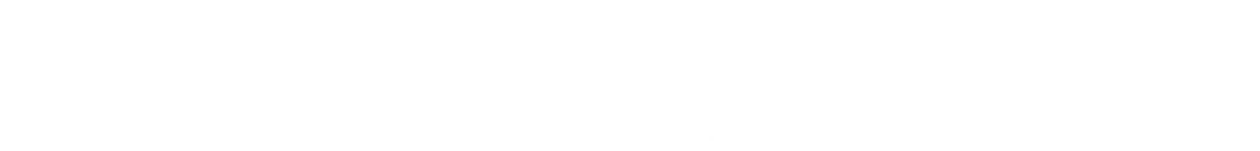

100%|██████████| 19/19 [00:00<00:00, 37.20it/s]


Epoch: 11 | disc_loss: -0.9343044757843018 | gen_loss: 0.9347440004348755


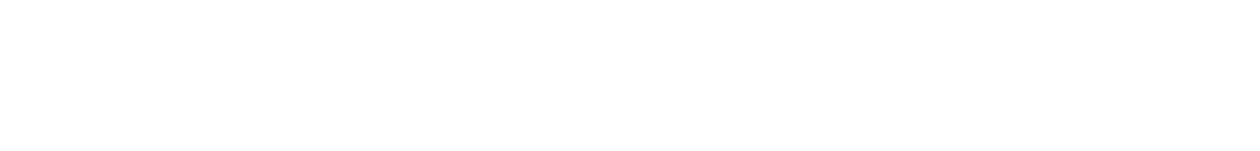

100%|██████████| 19/19 [00:00<00:00, 36.10it/s]


Epoch: 12 | disc_loss: -0.8880900144577026 | gen_loss: 0.9418650269508362


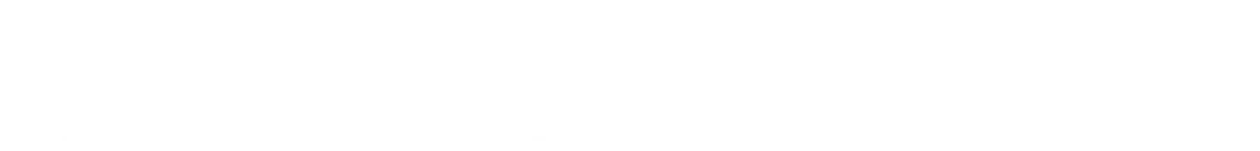

100%|██████████| 19/19 [00:00<00:00, 36.84it/s]


Epoch: 13 | disc_loss: -0.8758997917175293 | gen_loss: 0.9030763506889343


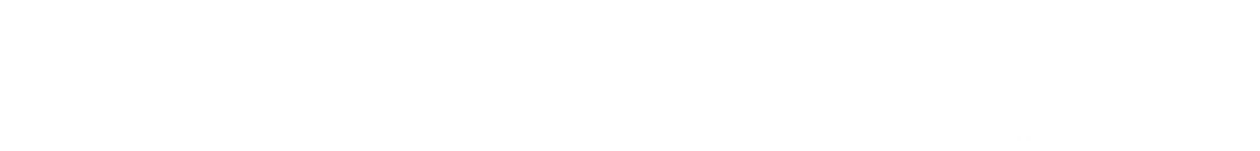

100%|██████████| 19/19 [00:00<00:00, 36.12it/s]


Epoch: 14 | disc_loss: -0.8990519642829895 | gen_loss: 0.9220642447471619


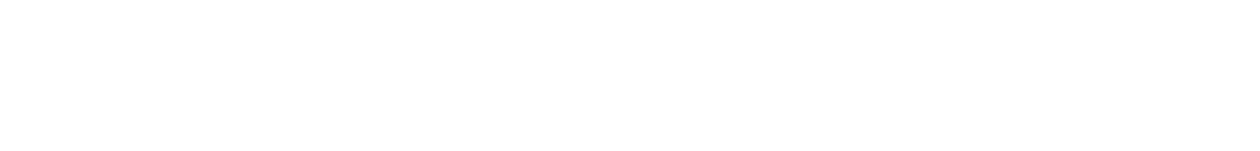

100%|██████████| 19/19 [00:00<00:00, 27.65it/s]


Epoch: 15 | disc_loss: -0.9239130616188049 | gen_loss: 0.9295845031738281


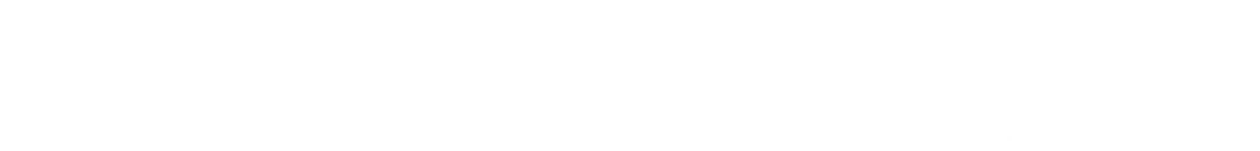

100%|██████████| 19/19 [00:00<00:00, 36.58it/s]


Epoch: 16 | disc_loss: -0.8948100209236145 | gen_loss: 0.9375899434089661


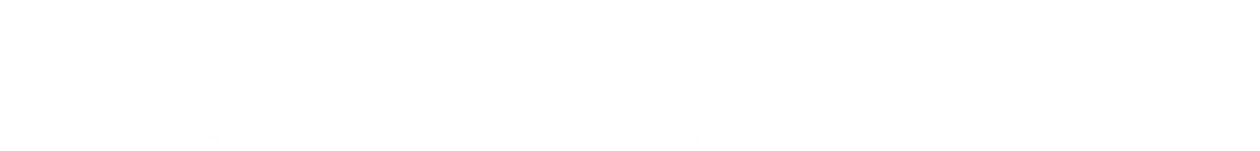

100%|██████████| 19/19 [00:00<00:00, 36.46it/s]


Epoch: 17 | disc_loss: -0.9191086292266846 | gen_loss: 0.9371107220649719


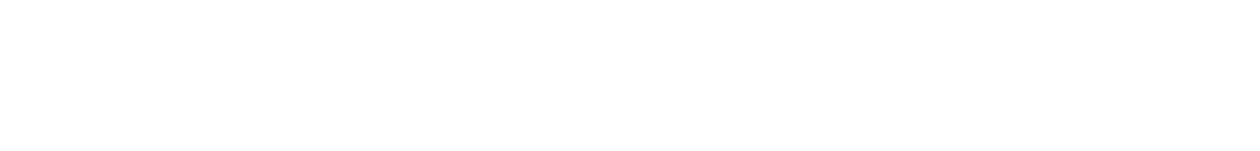

100%|██████████| 19/19 [00:00<00:00, 36.57it/s]


Epoch: 18 | disc_loss: -0.8766055107116699 | gen_loss: 0.9443145394325256


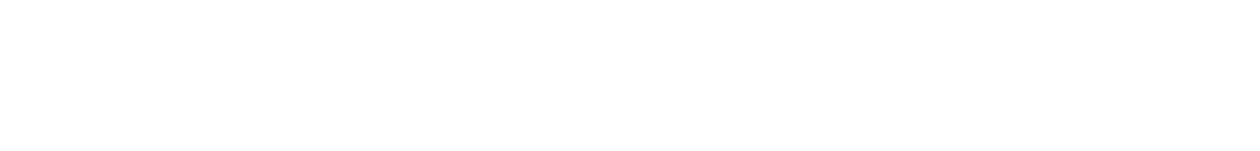

100%|██████████| 19/19 [00:00<00:00, 36.98it/s]


Epoch: 19 | disc_loss: -0.8776150941848755 | gen_loss: 0.9232304096221924


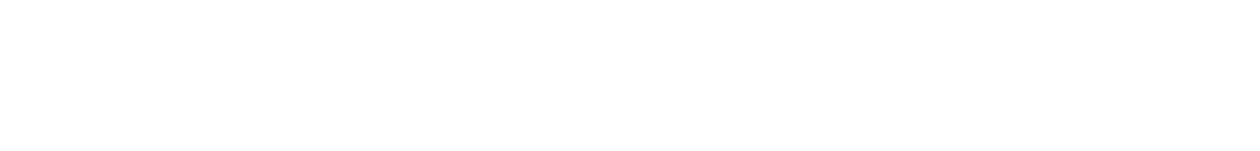

100%|██████████| 19/19 [00:00<00:00, 28.53it/s]


Epoch: 20 | disc_loss: -0.9046790599822998 | gen_loss: 0.918881893157959


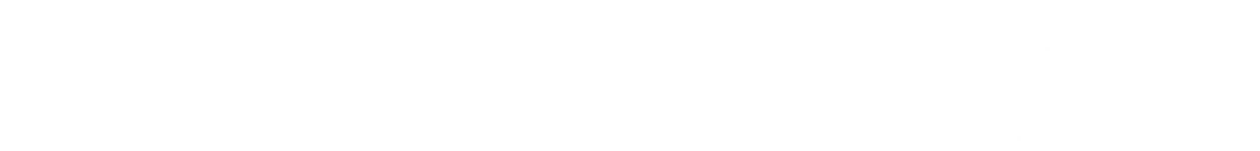

100%|██████████| 19/19 [00:00<00:00, 37.10it/s]


Epoch: 21 | disc_loss: -0.9078125357627869 | gen_loss: 0.9299741983413696


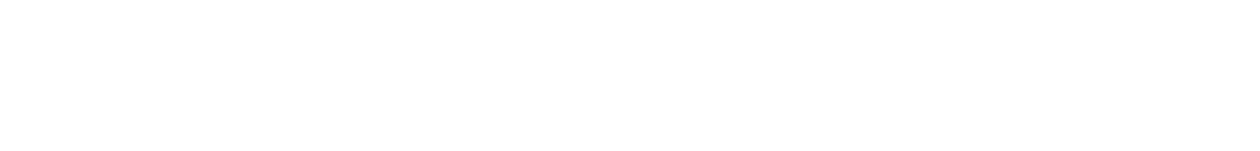

100%|██████████| 19/19 [00:00<00:00, 36.23it/s]


Epoch: 22 | disc_loss: -0.9033856391906738 | gen_loss: 0.9391128420829773


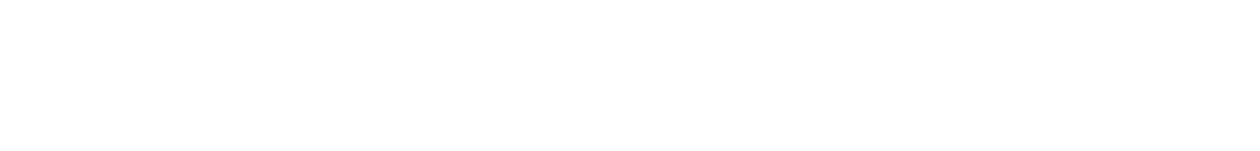

100%|██████████| 19/19 [00:00<00:00, 36.41it/s]


Epoch: 23 | disc_loss: -0.9031642079353333 | gen_loss: 0.9438055157661438


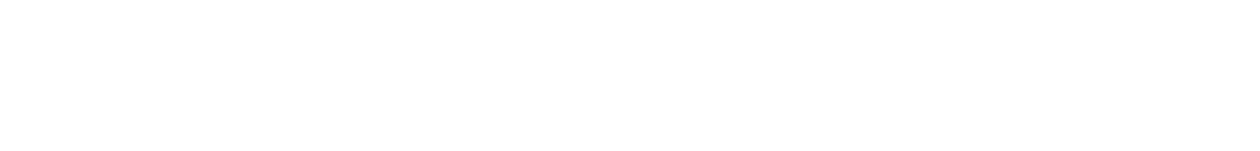

100%|██████████| 19/19 [00:00<00:00, 36.72it/s]


Epoch: 24 | disc_loss: -0.9141257405281067 | gen_loss: 0.9352623820304871


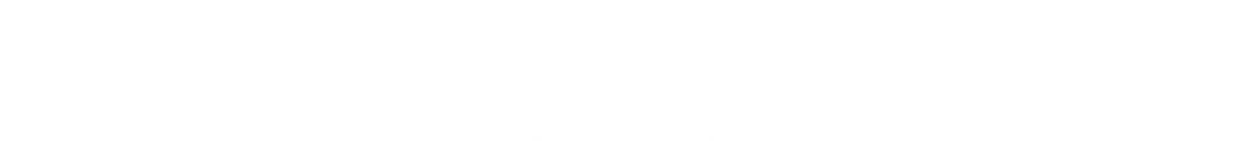

100%|██████████| 19/19 [00:00<00:00, 28.24it/s]


Epoch: 25 | disc_loss: -0.9035974740982056 | gen_loss: 0.9404990673065186


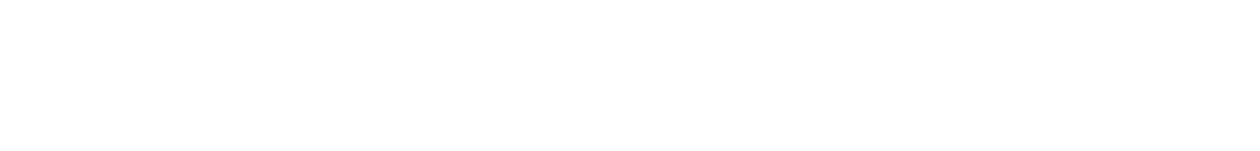

100%|██████████| 19/19 [00:00<00:00, 36.98it/s]


Epoch: 26 | disc_loss: -0.929144024848938 | gen_loss: 0.9401987195014954


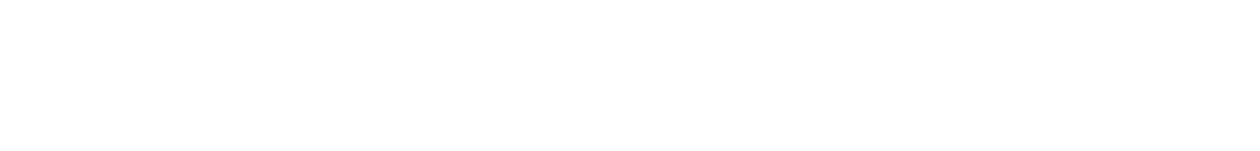

100%|██████████| 19/19 [00:00<00:00, 37.31it/s]


Epoch: 27 | disc_loss: -0.9163168668746948 | gen_loss: 0.9330585598945618


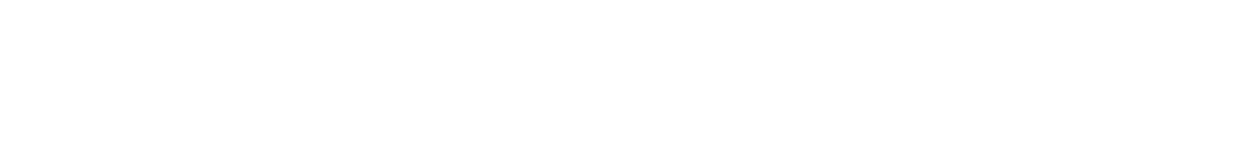

100%|██████████| 19/19 [00:00<00:00, 35.82it/s]


Epoch: 28 | disc_loss: -0.9115211367607117 | gen_loss: 0.9429294466972351


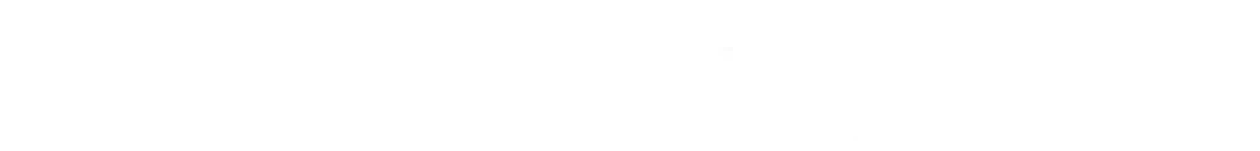

100%|██████████| 19/19 [00:00<00:00, 35.62it/s]


Epoch: 29 | disc_loss: -0.9091566801071167 | gen_loss: 0.942375659942627


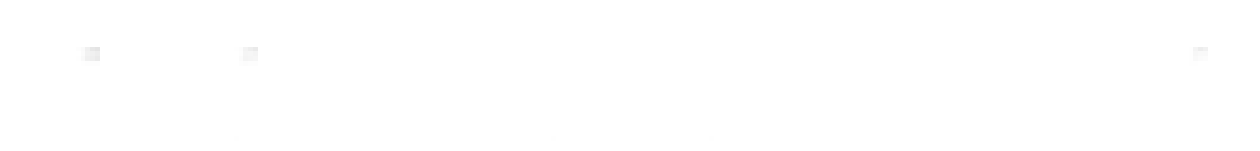

100%|██████████| 19/19 [00:00<00:00, 32.22it/s]


Epoch: 30 | disc_loss: -0.9146467447280884 | gen_loss: 0.9462965726852417


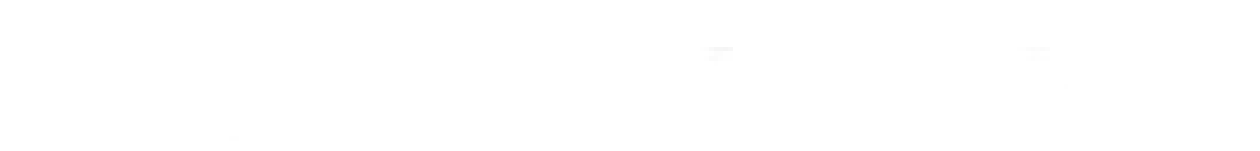

100%|██████████| 19/19 [00:00<00:00, 34.96it/s]


Epoch: 31 | disc_loss: -0.9184921383857727 | gen_loss: 0.9509591460227966


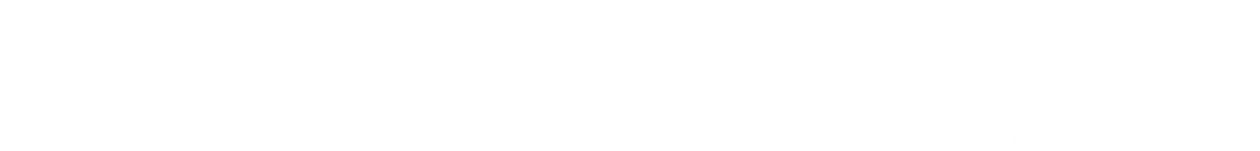

100%|██████████| 19/19 [00:00<00:00, 31.53it/s]


Epoch: 32 | disc_loss: -0.9128115773200989 | gen_loss: 0.940416157245636


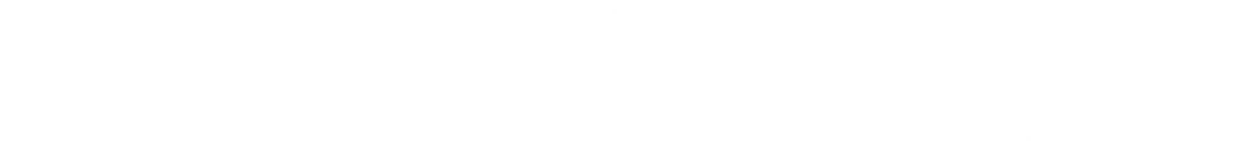

100%|██████████| 19/19 [00:00<00:00, 36.27it/s]


Epoch: 33 | disc_loss: -0.9113684296607971 | gen_loss: 0.9362512826919556


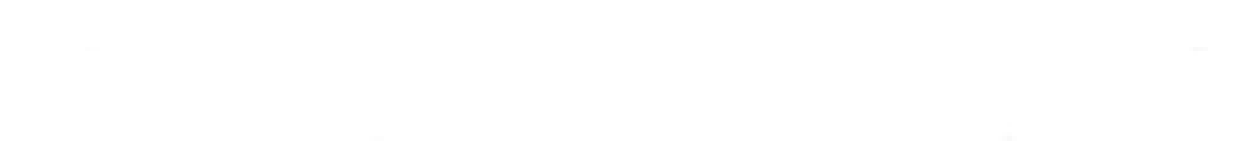

100%|██████████| 19/19 [00:00<00:00, 36.27it/s]


Epoch: 34 | disc_loss: 4.85745096206665 | gen_loss: 2.6163017537328415e-05


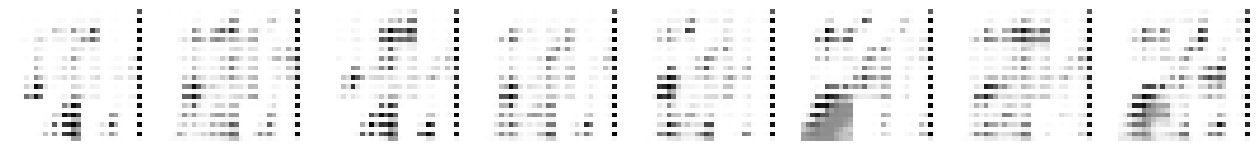

100%|██████████| 19/19 [00:00<00:00, 35.70it/s]


Epoch: 35 | disc_loss: 0.30899137258529663 | gen_loss: 0.7336594462394714


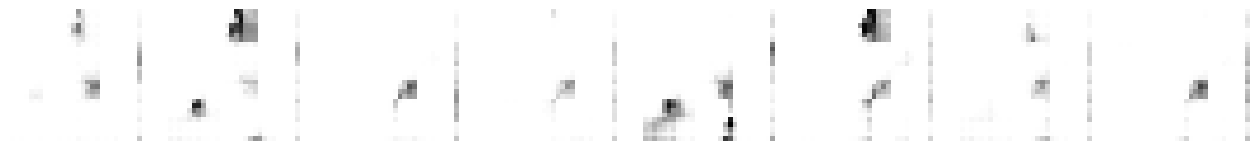

100%|██████████| 19/19 [00:00<00:00, 35.99it/s]


Epoch: 36 | disc_loss: 0.15257449448108673 | gen_loss: 0.8662227988243103


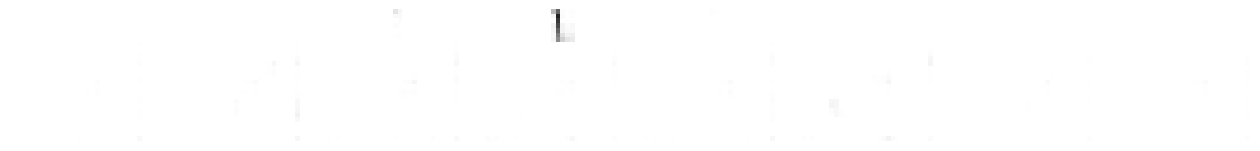

100%|██████████| 19/19 [00:00<00:00, 28.94it/s]


Epoch: 37 | disc_loss: 0.1003992035984993 | gen_loss: 0.9003210663795471


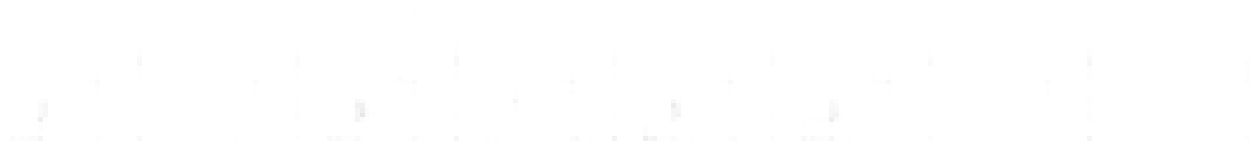

100%|██████████| 19/19 [00:00<00:00, 36.19it/s]


Epoch: 38 | disc_loss: 0.11451134085655212 | gen_loss: 0.9184374809265137


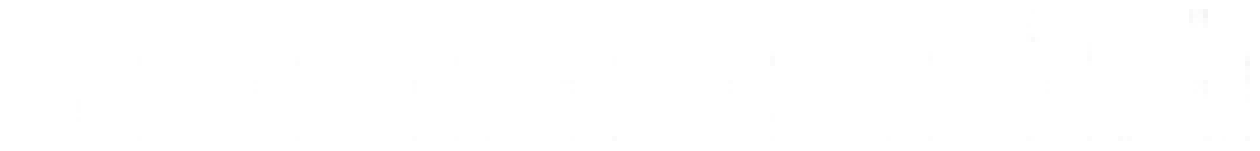

100%|██████████| 19/19 [00:00<00:00, 36.34it/s]


Epoch: 39 | disc_loss: 0.10151906311511993 | gen_loss: 0.9166089296340942


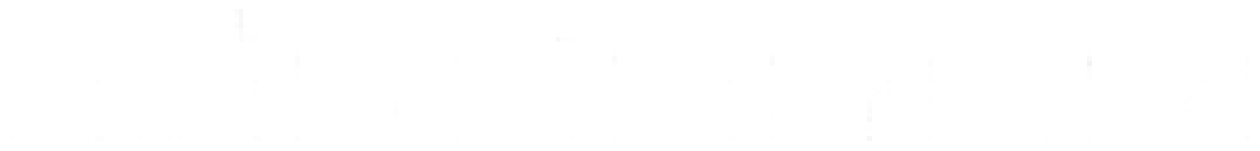

100%|██████████| 19/19 [00:00<00:00, 36.91it/s]


Epoch: 40 | disc_loss: 0.10455650091171265 | gen_loss: 0.9306966066360474


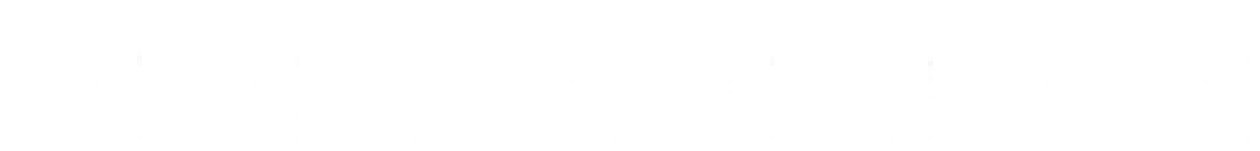

100%|██████████| 19/19 [00:00<00:00, 36.50it/s]


Epoch: 41 | disc_loss: 0.18542185425758362 | gen_loss: 0.9450453519821167


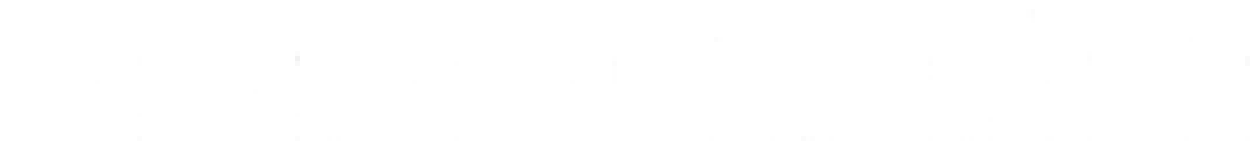

100%|██████████| 19/19 [00:00<00:00, 28.43it/s]


Epoch: 42 | disc_loss: 0.0988960787653923 | gen_loss: 0.9331610798835754


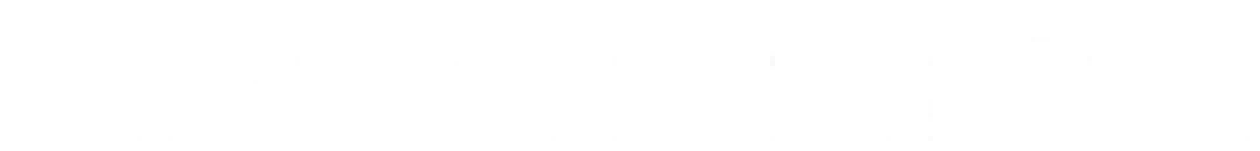

100%|██████████| 19/19 [00:00<00:00, 35.65it/s]


Epoch: 43 | disc_loss: 0.10320065170526505 | gen_loss: 0.9416921734809875


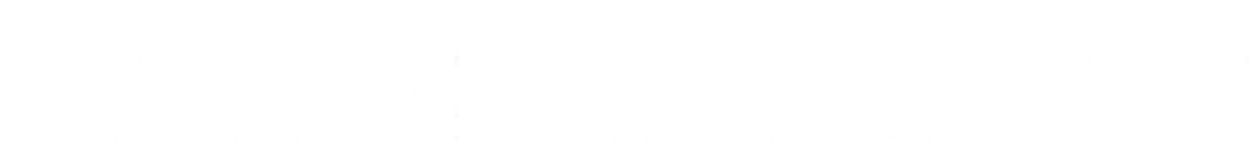

100%|██████████| 19/19 [00:00<00:00, 35.87it/s]


Epoch: 44 | disc_loss: 0.09025886654853821 | gen_loss: 0.9345042705535889


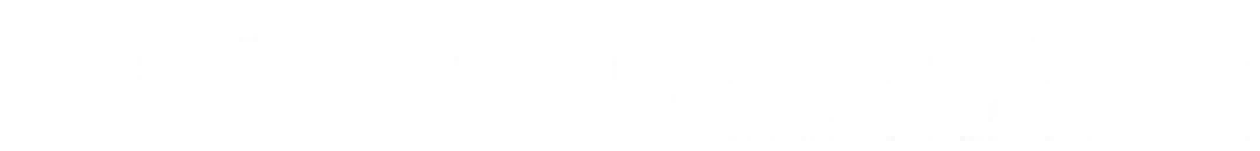

100%|██████████| 19/19 [00:00<00:00, 35.54it/s]


Epoch: 45 | disc_loss: 0.2739552855491638 | gen_loss: 0.961796224117279


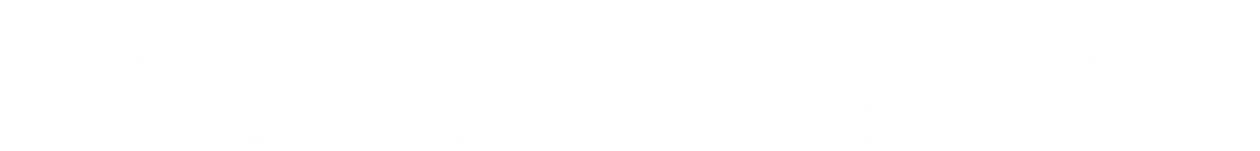

100%|██████████| 19/19 [00:00<00:00, 36.43it/s]


Epoch: 46 | disc_loss: 0.09588979929685593 | gen_loss: 0.9449405670166016


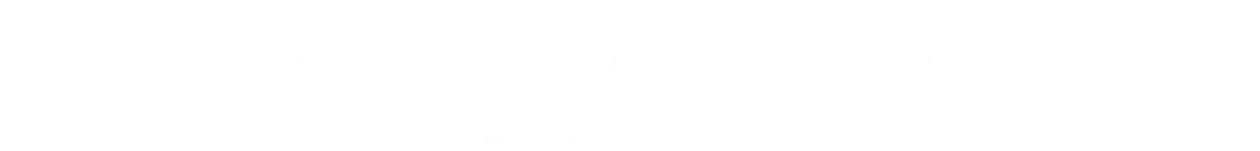

100%|██████████| 19/19 [00:00<00:00, 26.43it/s]


Epoch: 47 | disc_loss: 0.09746803343296051 | gen_loss: 0.9496537446975708


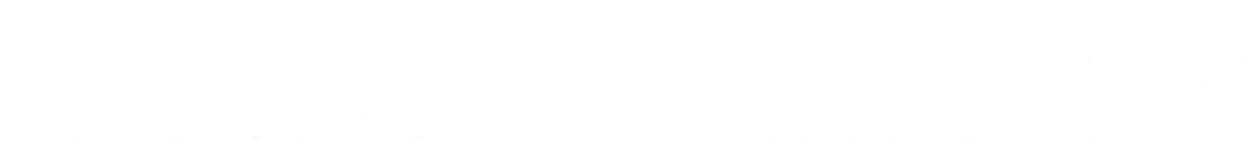

100%|██████████| 19/19 [00:00<00:00, 34.72it/s]


Epoch: 48 | disc_loss: 0.0819314569234848 | gen_loss: 0.9420344829559326


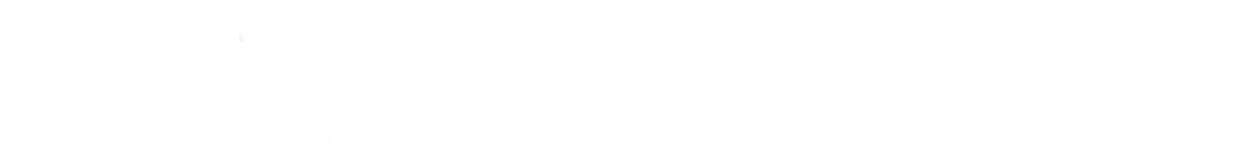

100%|██████████| 19/19 [00:00<00:00, 35.64it/s]


Epoch: 49 | disc_loss: -0.9040343761444092 | gen_loss: 0.9474268555641174


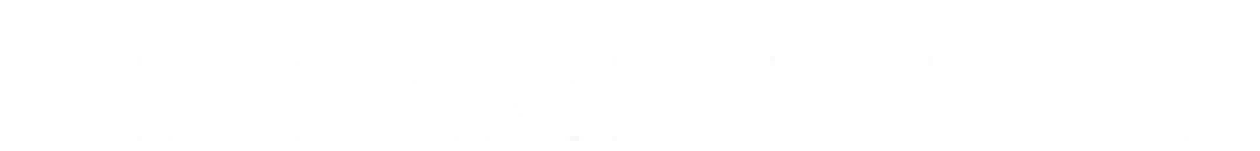

100%|██████████| 19/19 [00:00<00:00, 36.99it/s]


Epoch: 50 | disc_loss: -0.9172896146774292 | gen_loss: 0.9421756863594055


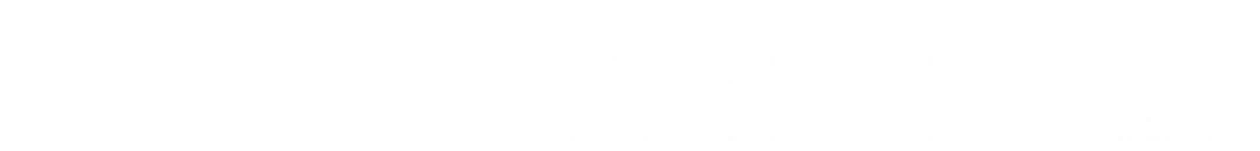

100%|██████████| 19/19 [00:00<00:00, 36.64it/s]


Epoch: 51 | disc_loss: -0.9116187691688538 | gen_loss: 0.9499781727790833


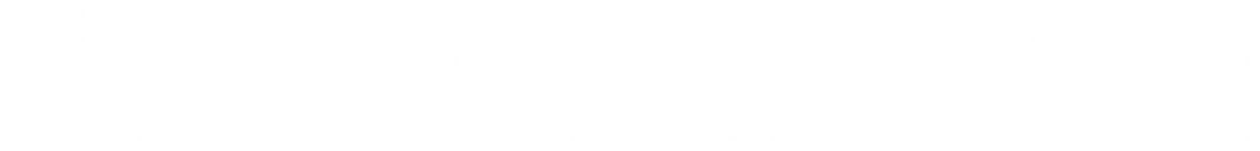

100%|██████████| 19/19 [00:00<00:00, 28.90it/s]


Epoch: 52 | disc_loss: -0.9210163950920105 | gen_loss: 0.9454395771026611


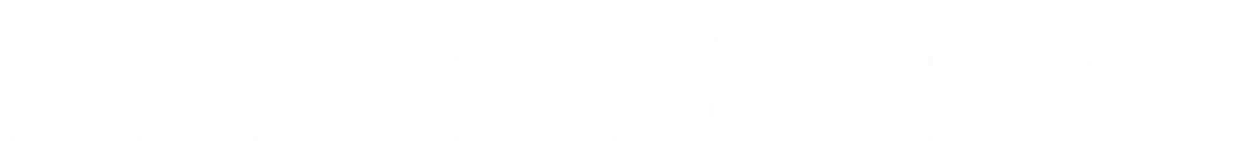

100%|██████████| 19/19 [00:00<00:00, 36.24it/s]


Epoch: 53 | disc_loss: -0.9222777485847473 | gen_loss: 0.9527014493942261


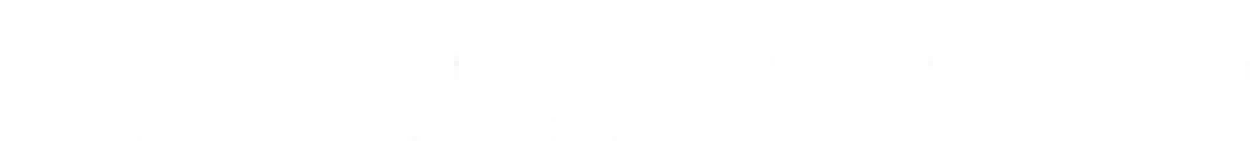

100%|██████████| 19/19 [00:00<00:00, 31.59it/s]


Epoch: 54 | disc_loss: -0.921319842338562 | gen_loss: 0.9481406807899475


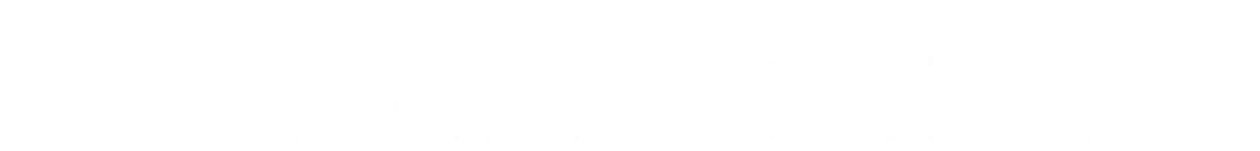

100%|██████████| 19/19 [00:00<00:00, 37.18it/s]


Epoch: 55 | disc_loss: -0.930661678314209 | gen_loss: 0.9515990018844604


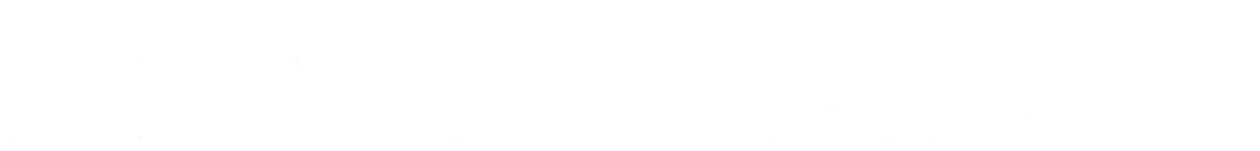

100%|██████████| 19/19 [00:00<00:00, 31.39it/s]


Epoch: 56 | disc_loss: -0.9221011996269226 | gen_loss: 0.9454312324523926


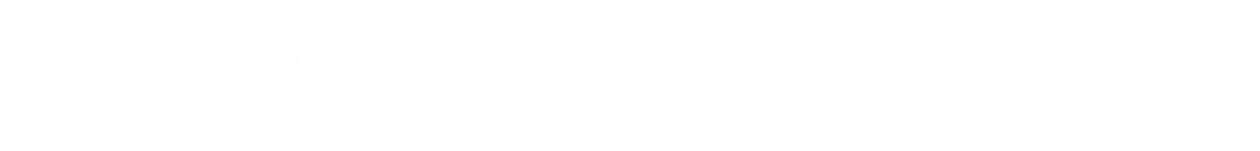

100%|██████████| 19/19 [00:00<00:00, 36.15it/s]


Epoch: 57 | disc_loss: -0.9328370094299316 | gen_loss: 0.9486895203590393


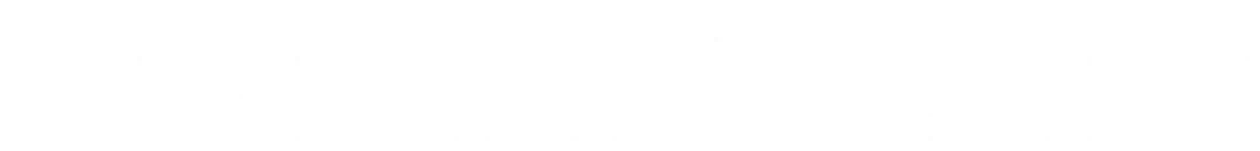

100%|██████████| 19/19 [00:00<00:00, 36.65it/s]


Epoch: 58 | disc_loss: -0.9015880227088928 | gen_loss: 0.9474400877952576


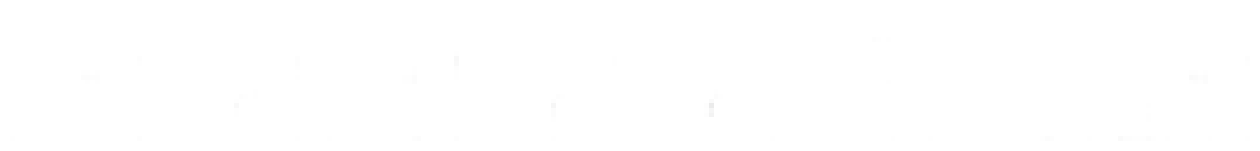

100%|██████████| 19/19 [00:00<00:00, 35.83it/s]


Epoch: 59 | disc_loss: -0.9106517434120178 | gen_loss: 0.947533130645752


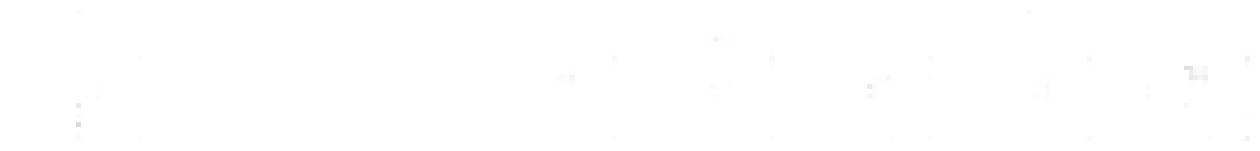

100%|██████████| 19/19 [00:00<00:00, 35.65it/s]


Epoch: 60 | disc_loss: 0.5884686708450317 | gen_loss: 0.7867317199707031


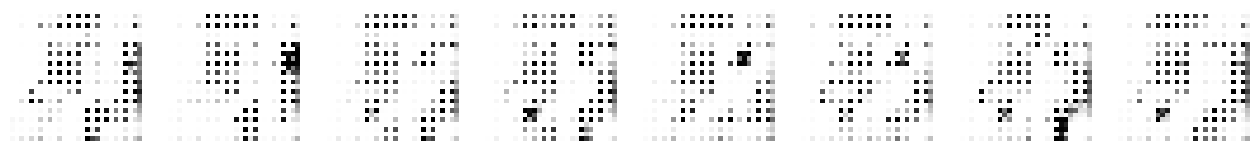

100%|██████████| 19/19 [00:00<00:00, 30.74it/s]


Epoch: 61 | disc_loss: 0.10681267827749252 | gen_loss: 0.9412441253662109


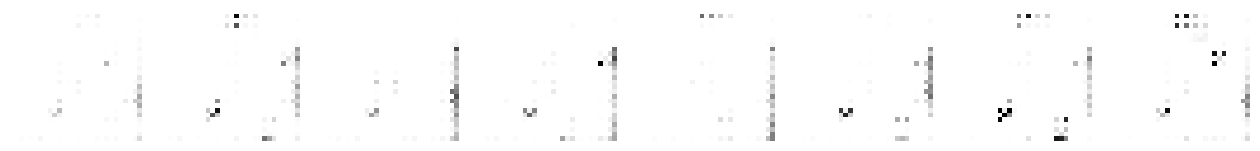

100%|██████████| 19/19 [00:00<00:00, 37.06it/s]


Epoch: 62 | disc_loss: 0.08833405375480652 | gen_loss: 0.9317919015884399


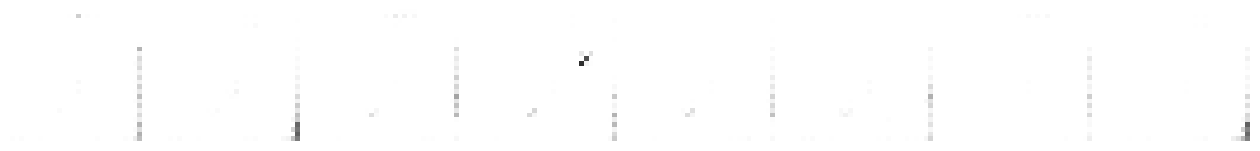

100%|██████████| 19/19 [00:00<00:00, 28.34it/s]


Epoch: 63 | disc_loss: 0.08317527920007706 | gen_loss: 0.9420109987258911


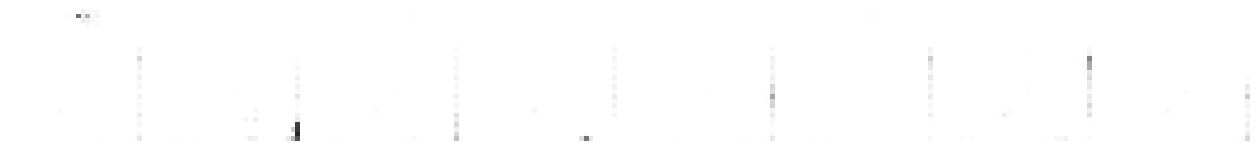

100%|██████████| 19/19 [00:00<00:00, 35.16it/s]


Epoch: 64 | disc_loss: 0.06812196224927902 | gen_loss: 0.9353886842727661


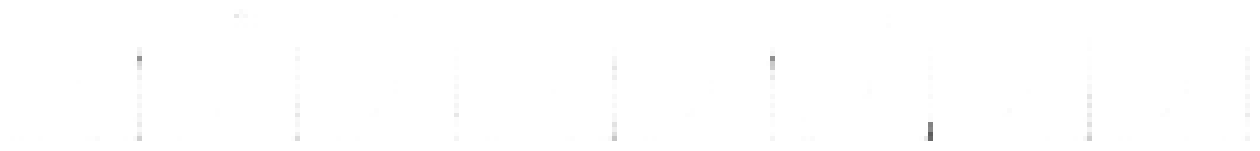

100%|██████████| 19/19 [00:00<00:00, 34.56it/s]


Epoch: 65 | disc_loss: 0.07966502755880356 | gen_loss: 0.9459515810012817


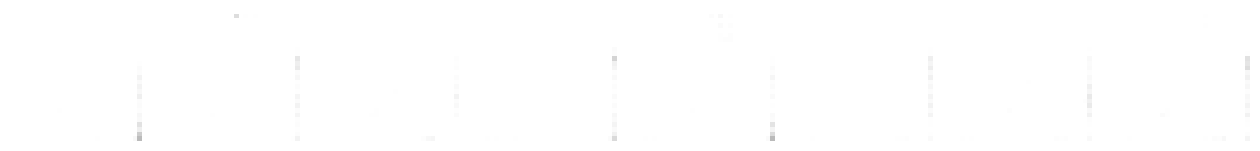

100%|██████████| 19/19 [00:00<00:00, 36.15it/s]


Epoch: 66 | disc_loss: 0.08478386700153351 | gen_loss: 0.9419748187065125


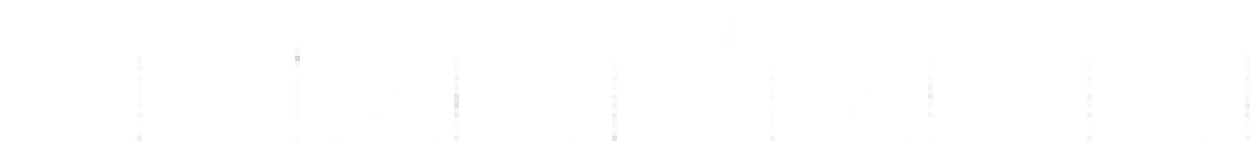

100%|██████████| 19/19 [00:00<00:00, 28.99it/s]


Epoch: 67 | disc_loss: 0.08102517575025558 | gen_loss: 0.9438727498054504


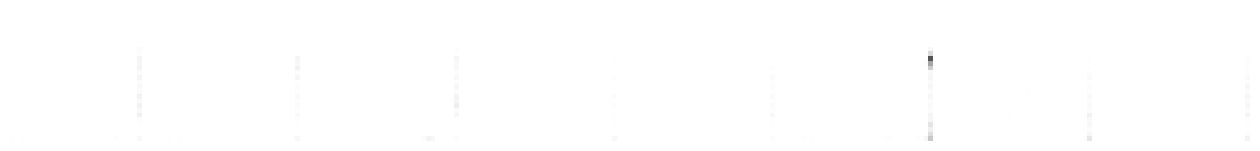

100%|██████████| 19/19 [00:00<00:00, 29.49it/s]


Epoch: 68 | disc_loss: 0.07861778140068054 | gen_loss: 0.9513289928436279


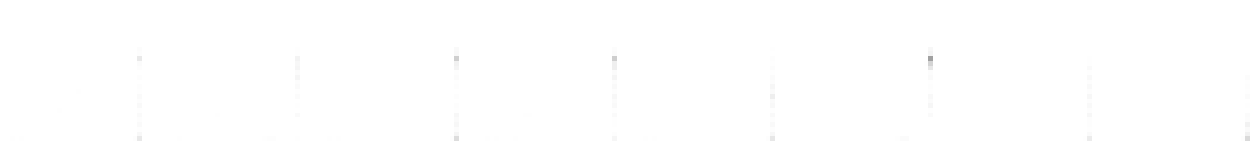

100%|██████████| 19/19 [00:00<00:00, 36.14it/s]


Epoch: 69 | disc_loss: 0.09368938207626343 | gen_loss: 0.9581066966056824


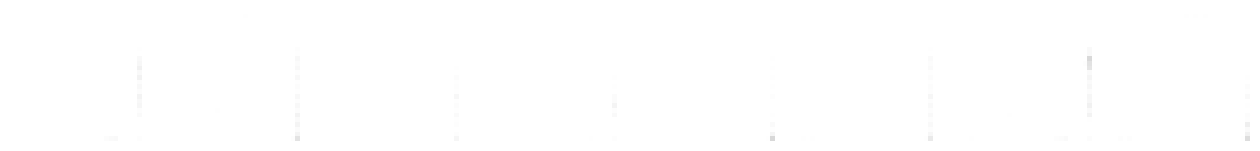

100%|██████████| 19/19 [00:00<00:00, 36.55it/s]


Epoch: 70 | disc_loss: 0.06678552180528641 | gen_loss: 0.9528399109840393


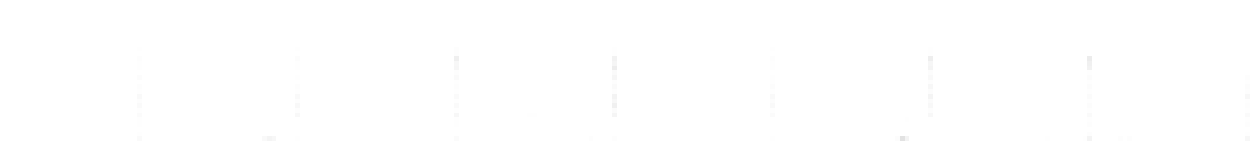

100%|██████████| 19/19 [00:00<00:00, 35.87it/s]


Epoch: 71 | disc_loss: 0.05106145516037941 | gen_loss: 0.9576098918914795


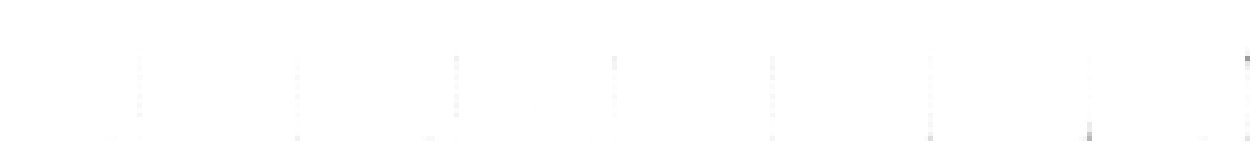

100%|██████████| 19/19 [00:00<00:00, 36.31it/s]


Epoch: 72 | disc_loss: -0.9391120076179504 | gen_loss: 0.9546592235565186


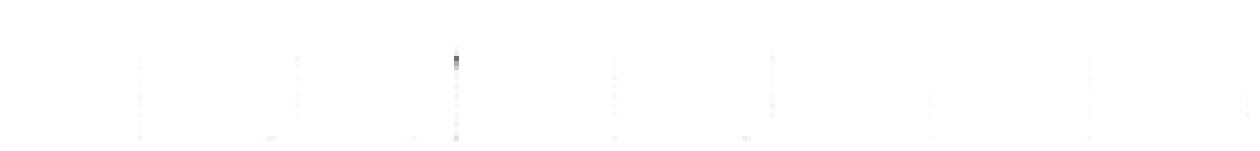

100%|██████████| 19/19 [00:00<00:00, 26.31it/s]


Epoch: 73 | disc_loss: -0.9235723614692688 | gen_loss: 0.9528989195823669


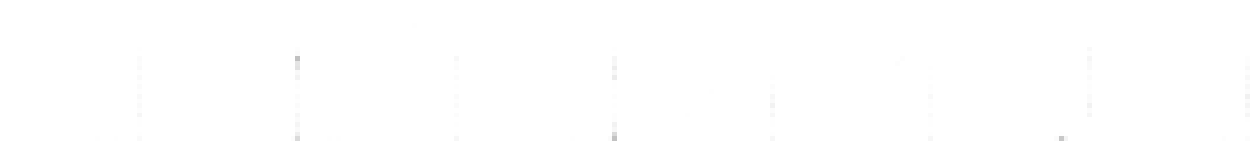

100%|██████████| 19/19 [00:00<00:00, 36.14it/s]


Epoch: 74 | disc_loss: -0.9322831034660339 | gen_loss: 0.9589255452156067


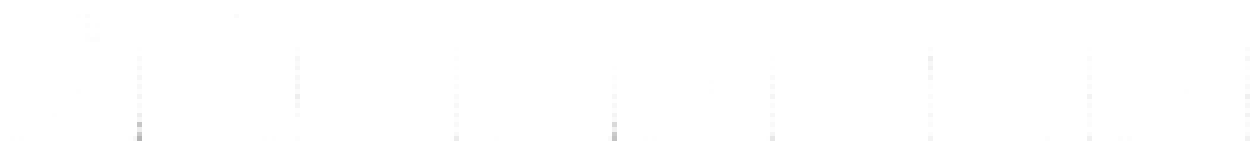

100%|██████████| 19/19 [00:00<00:00, 36.59it/s]


Epoch: 75 | disc_loss: -0.9304747581481934 | gen_loss: 0.9551795125007629


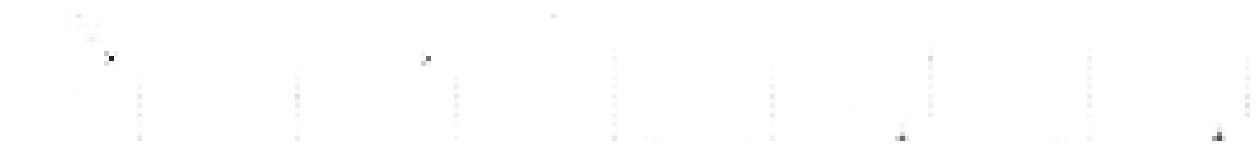

100%|██████████| 19/19 [00:00<00:00, 35.91it/s]


Epoch: 76 | disc_loss: -0.9280540347099304 | gen_loss: 0.960030734539032


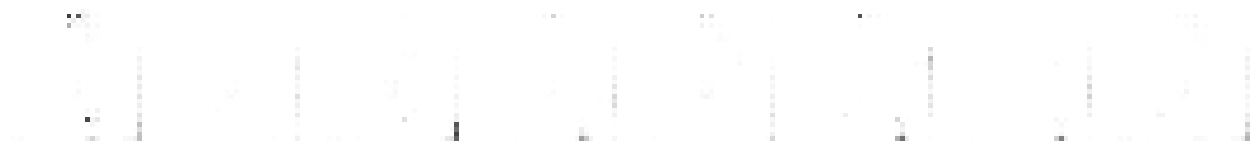

100%|██████████| 19/19 [00:00<00:00, 34.46it/s]


Epoch: 77 | disc_loss: -0.9377455711364746 | gen_loss: 0.9558072090148926


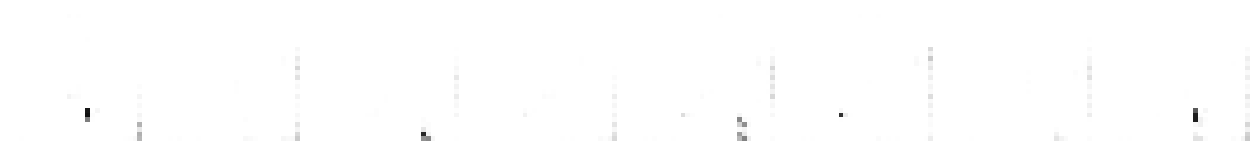

100%|██████████| 19/19 [00:00<00:00, 33.95it/s]


Epoch: 78 | disc_loss: -0.9145383238792419 | gen_loss: 0.9445058703422546


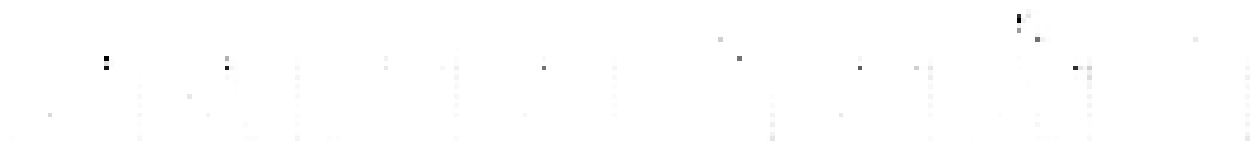

100%|██████████| 19/19 [00:00<00:00, 35.60it/s]


Epoch: 79 | disc_loss: -0.9379503130912781 | gen_loss: 0.9509873390197754


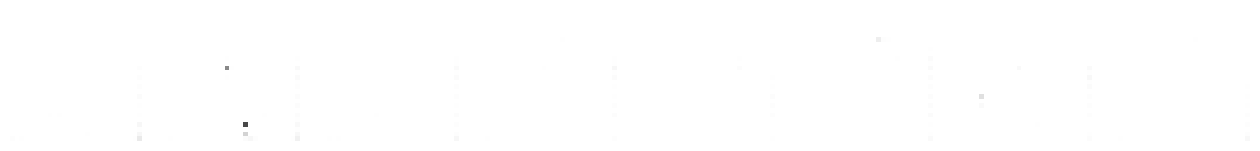

100%|██████████| 19/19 [00:00<00:00, 29.23it/s]


Epoch: 80 | disc_loss: -0.9359319806098938 | gen_loss: 0.9489666819572449


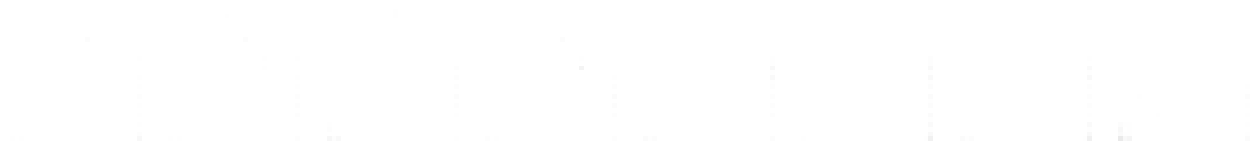

100%|██████████| 19/19 [00:00<00:00, 35.51it/s]


Epoch: 81 | disc_loss: -0.9549510478973389 | gen_loss: 0.9551758766174316


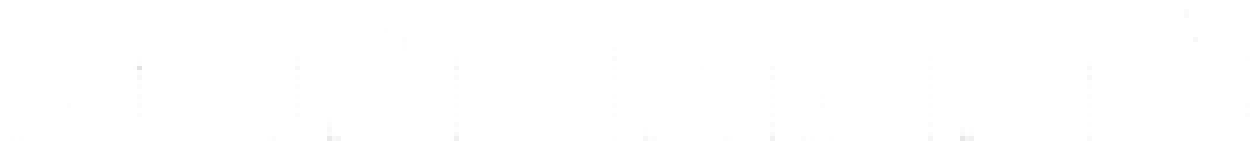

100%|██████████| 19/19 [00:00<00:00, 36.15it/s]


Epoch: 82 | disc_loss: -0.9075937867164612 | gen_loss: 0.9546866416931152


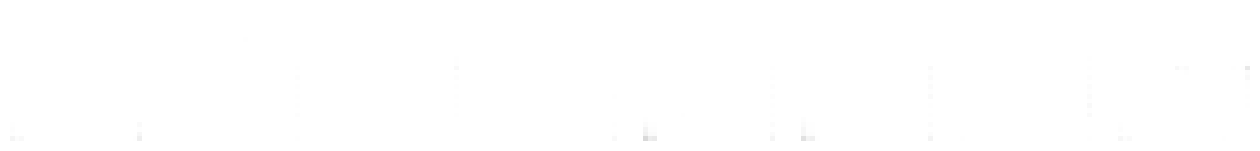

100%|██████████| 19/19 [00:00<00:00, 35.79it/s]


Epoch: 83 | disc_loss: -0.9355423450469971 | gen_loss: 0.9603387713432312


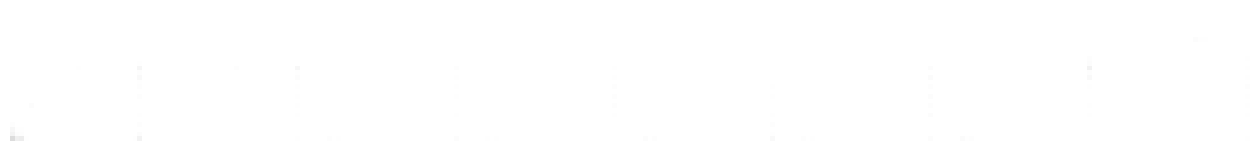

100%|██████████| 19/19 [00:00<00:00, 36.21it/s]


Epoch: 84 | disc_loss: -0.9353840351104736 | gen_loss: 0.9578664898872375


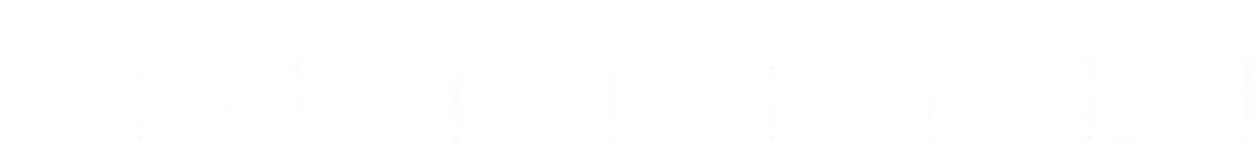

100%|██████████| 19/19 [00:00<00:00, 28.24it/s]


Epoch: 85 | disc_loss: -0.927630603313446 | gen_loss: 0.9589594006538391


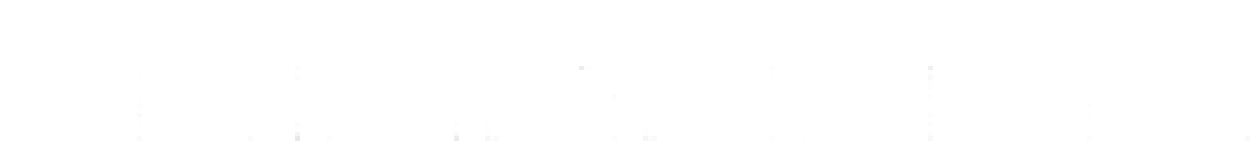

100%|██████████| 19/19 [00:00<00:00, 37.11it/s]


Epoch: 86 | disc_loss: -0.9323029518127441 | gen_loss: 0.9633826017379761


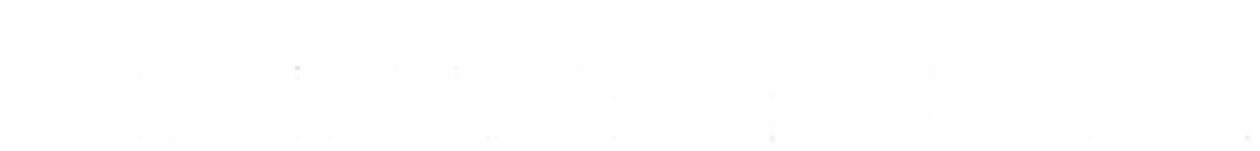

100%|██████████| 19/19 [00:00<00:00, 36.10it/s]


Epoch: 87 | disc_loss: -0.9375604391098022 | gen_loss: 0.9603261351585388


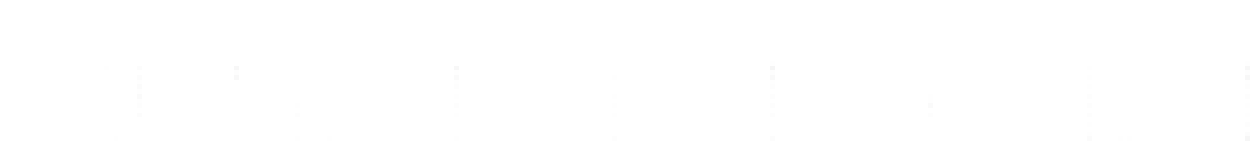

100%|██████████| 19/19 [00:00<00:00, 36.43it/s]


Epoch: 88 | disc_loss: -0.9515888690948486 | gen_loss: 0.9614733457565308


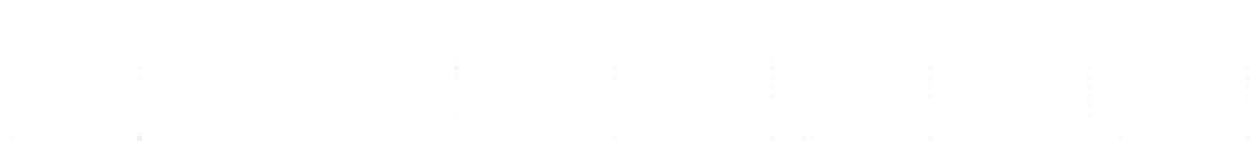

100%|██████████| 19/19 [00:00<00:00, 34.35it/s]


Epoch: 89 | disc_loss: -0.9371656179428101 | gen_loss: 0.9655965566635132


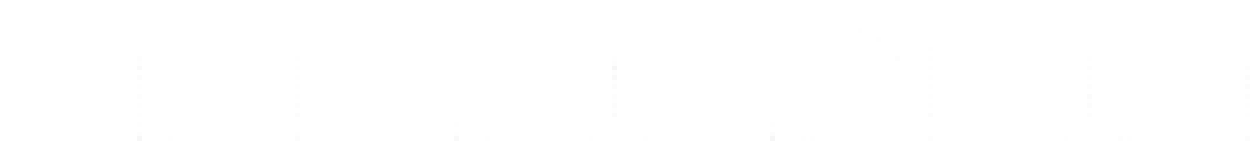

100%|██████████| 19/19 [00:00<00:00, 31.36it/s]


Epoch: 90 | disc_loss: -0.9400124549865723 | gen_loss: 0.9625790119171143


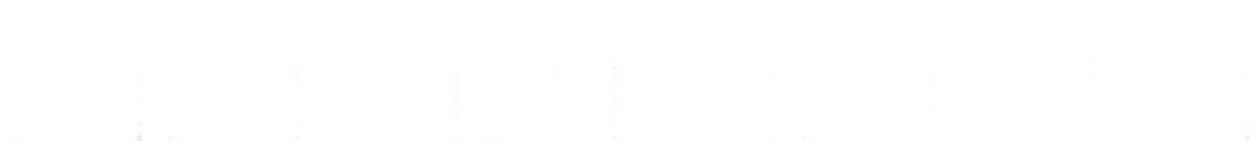

100%|██████████| 19/19 [00:00<00:00, 35.64it/s]


Epoch: 91 | disc_loss: -0.9295752644538879 | gen_loss: 0.9671263694763184


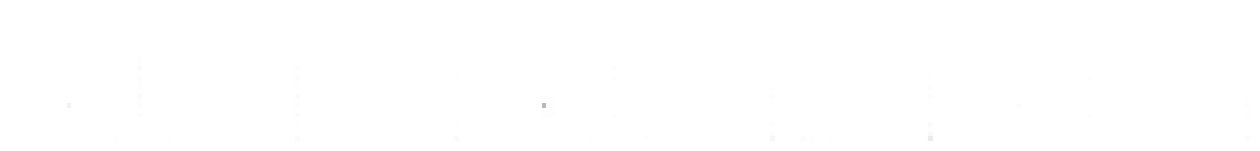

100%|██████████| 19/19 [00:00<00:00, 33.19it/s]


Epoch: 92 | disc_loss: -0.9549316763877869 | gen_loss: 0.956693172454834


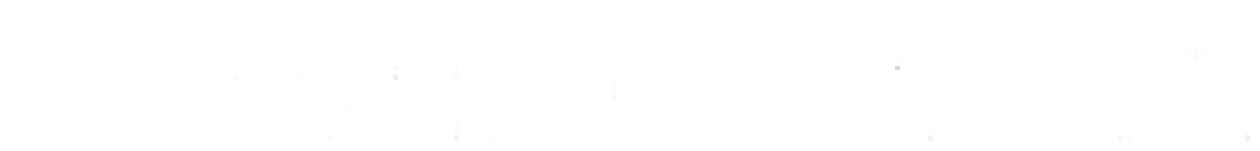

100%|██████████| 19/19 [00:00<00:00, 35.77it/s]


Epoch: 93 | disc_loss: -0.9349176287651062 | gen_loss: 0.9581623077392578


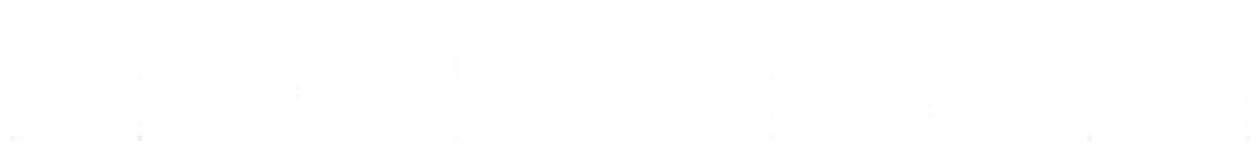

100%|██████████| 19/19 [00:00<00:00, 35.32it/s]


Epoch: 94 | disc_loss: -0.9366352558135986 | gen_loss: 0.9559131264686584


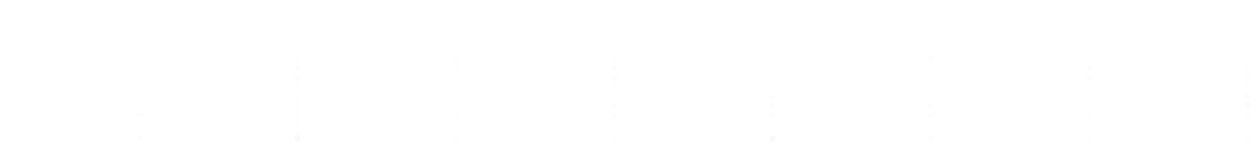

100%|██████████| 19/19 [00:00<00:00, 30.47it/s]


Epoch: 95 | disc_loss: -0.9338704347610474 | gen_loss: 0.9613406658172607


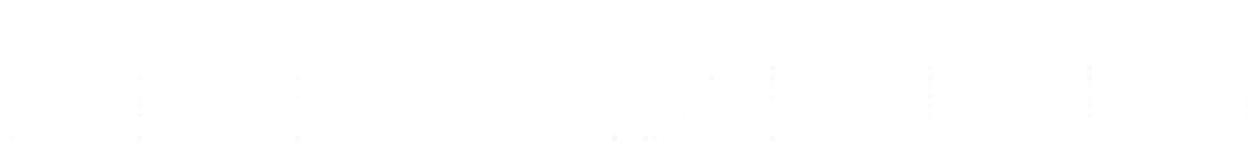

100%|██████████| 19/19 [00:00<00:00, 36.38it/s]


Epoch: 96 | disc_loss: -0.9299033284187317 | gen_loss: 0.9625959992408752


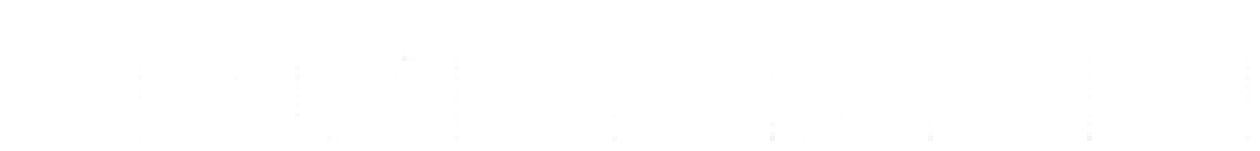

100%|██████████| 19/19 [00:00<00:00, 36.59it/s]


Epoch: 97 | disc_loss: -0.942297101020813 | gen_loss: 0.9592577219009399


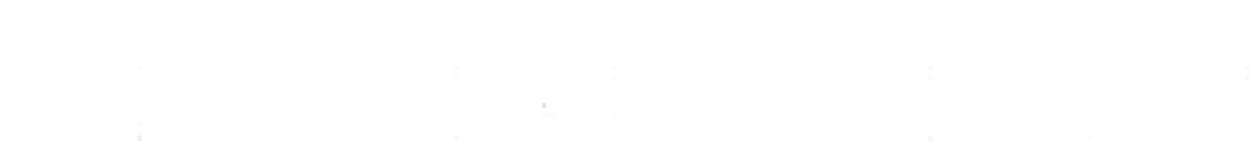

100%|██████████| 19/19 [00:00<00:00, 36.13it/s]


Epoch: 98 | disc_loss: -0.9270094633102417 | gen_loss: 0.9643651247024536


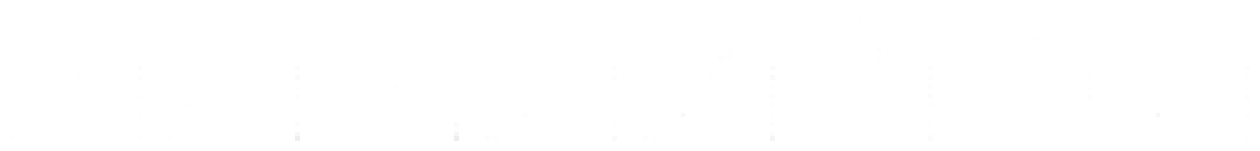

100%|██████████| 19/19 [00:00<00:00, 36.08it/s]


Epoch: 99 | disc_loss: -0.9419379830360413 | gen_loss: 0.959845781326294


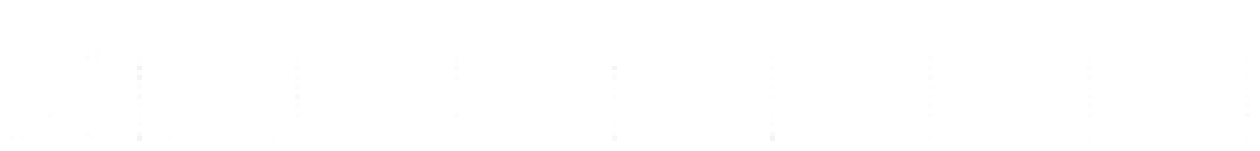

In [ ]:
n_epochs = 100

for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES):
        model.train(train_x)

    # test on holdout
    loss = []
    for batch, test_x in tqdm(zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES):
        loss.append(model.compute_loss(test_x))

    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    # display.clear_output()
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    plot_reconstruction(model)

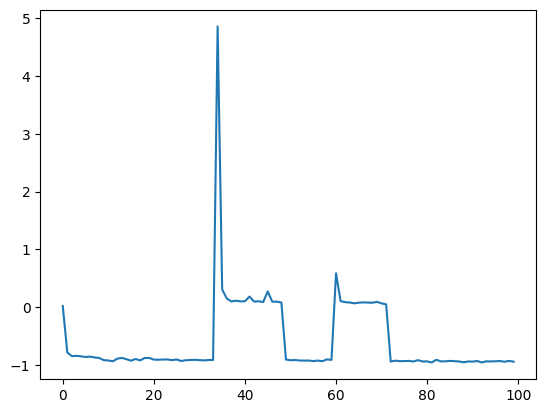

In [ ]:
plt.plot(losses.disc_loss)

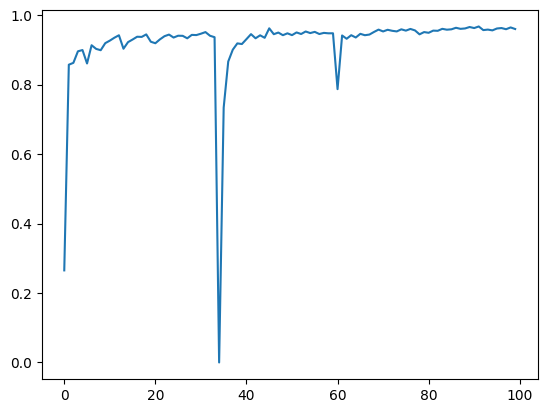

In [ ]:
plt.plot(losses.gen_loss)

In [ ]:
losses